# Add "transport emissions" to food dataset from trade matrix analysis at /food_trading

Trade matrix does not include regions. I will take the global totals and merge with "world" region from the full food dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load trade matrix and aggregate by "World"

In [2]:
trade_df = pd.read_parquet(r'..\data\FAOSTAT\clean_data\food_trading\trade_matrix_carbon_footprint_v4.parquet')

In [3]:
trade_df.head()

,Reporter Country Code,Partner Country Code,Item Code,Year,Value_tons,Flag,distance_in_km,same_continent,share_border,any_island_or_missing,transportation_method,food_miles,kgCO2eq_tkm
0,4,2,231,2005,3.00,A,5855.362822,0,0.0,0,water,1.756609e+04,175.660885
1,3,3,56,2005,52.00,A,108.698297,1,1.0,0,land,5.652311e+03,1130.462293
2,7,2,176,2022,25.06,A,7596.963990,0,0.0,0,water,1.903799e+05,1903.799176
3,4,2,711,1996,171.00,A,5855.362822,0,0.0,0,water,1.001267e+06,10012.670425
4,4,2,711,1997,160.00,A,5855.362822,0,0.0,0,water,9.368581e+05,9368.580515


In [4]:
sum_columns = ["Value_tons", "distance_in_km", "food_miles", "kgCO2eq_tkm"]

global_trade_df = trade_df.groupby(['Year', 'Item Code'])[sum_columns].sum().reset_index()

In [5]:
global_trade_df['Area'] = 'World'
global_trade_df

,Year,Item Code,Value_tons,distance_in_km,food_miles,kgCO2eq_tkm,Area
0,1986,15,46430864.00,1.645298e+06,3.208179e+11,5.655241e+09,World
1,1986,16,3108187.00,1.503858e+06,1.164173e+10,1.474037e+08,World
2,1986,17,1650788.00,7.064046e+05,1.106361e+10,1.793695e+08,World
3,1986,18,442442.00,3.272698e+06,1.742273e+09,7.442408e+07,World
4,1986,19,2303.00,6.427711e+04,2.834946e+06,8.414042e+04,World
...,...,...,...,...,...,...,...
15161,2022,1275,1877138.19,1.031489e+07,7.299531e+09,2.841683e+08,World
15162,2022,1276,8485591.05,8.855109e+06,5.242887e+10,1.504396e+09,World
15163,2022,1277,688103.82,9.256778e+05,3.494254e+09,9.738926e+07,World
15164,2022,1295,1002.00,1.464508e+05,3.482504e+06,6.063803e+04,World


## Merge with agreggated items table

In [6]:
global_trade_df['Item Code'].nunique()

452

In [7]:
new_items_df = pd.read_csv(r'..\data\FAOSTAT\clean_data\food_codes_categorized_final.csv', encoding = 'ISO-8859-1')
new_items_df.dropna(subset='Item_emissions_table', inplace=True)
new_items_df['Item_code_emissions_table'] = new_items_df['Item_code_emissions_table'].astype('int64')

In [8]:
new_items_df.head()

,Item_Code,Item,conservation,diet,food_type,Item_code_emissions_table,Item_emissions_table
4,15,Wheat,Ambient,vegan,grain,15,Wheat
5,16,Wheat and meslin flour,Ambient,vegan,grain,15,Wheat
6,17,Bran of wheat,Ambient,vegan,grain,15,Wheat
8,19,Germ of wheat,Ambient,vegan,grain,15,Wheat
18,27,Rice,Ambient,vegan,grain,27,Rice


In [9]:
global_trade_df = pd.merge(global_trade_df, new_items_df, 
                               left_on='Item Code', right_on='Item_Code', how='inner')
global_trade_df.drop(columns=['Item_Code'], inplace=True)

In [10]:
global_trade_df.isnull().sum()

Year                         0
Item Code                    0
Value_tons                   0
distance_in_km               0
food_miles                   0
kgCO2eq_tkm                  0
Area                         0
Item                         0
conservation                 0
diet                         0
food_type                    0
Item_code_emissions_table    0
Item_emissions_table         0
dtype: int64

Group by new item to have one item per year

In [11]:
global_trade_df = global_trade_df.groupby(['Area', 'Year', 'Item_code_emissions_table', 'Item_emissions_table'])[sum_columns].sum().reset_index()


Add column in same unit as production emissions transport_TOTAL_(emissions_CO2eq)_(kt)

In [12]:
global_trade_df['transport_TOTAL_(emissions_CO2eq)_(kt)'] = global_trade_df['kgCO2eq_tkm'] / 1_000_000
global_trade_df.head()

,Area,Year,Item_code_emissions_table,Item_emissions_table,Value_tons,distance_in_km,food_miles,kgCO2eq_tkm,transport_TOTAL_(emissions_CO2eq)_(kt)
0,World,1986,15,Wheat,51192142.0,3.919838e+06,3.435260e+11,5.982098e+09,5982.098073
1,World,1986,27,Rice,6340439.0,5.668886e+06,4.193583e+10,1.284523e+09,1284.522907
2,World,1986,44,Barley,11123426.0,1.140790e+06,6.003850e+10,9.429385e+08,942.938524
3,World,1986,56,Maize (corn),43219692.0,4.756967e+06,3.098557e+11,6.907396e+09,6907.396197
4,World,1986,71,Rye,436017.0,2.721227e+05,2.498059e+09,4.492308e+07,44.923076


## Load full food dataset

In [13]:
full_food_df = pd.read_parquet(r'..\data\FAOSTAT\clean_data\all_tables_processed\full_food_dataset_v2_aggregated_byitem.parquet')

In [14]:
world_food_df = full_food_df[full_food_df['Area'] == 'World']

In [15]:
print(world_food_df.shape)
world_food_df.head()

(1281, 35)


,Area Code,Area,Year,Item Code,Item,crops_or_livestock,Stocks_(An),Burning_crop_residues_(Emissions_CH4_CO2eq)_(kt),Burning_crop_residues_(Emissions_N2O_CO2eq)_(kt),Crop_residues_(Emissions_N2O_CO2eq)_(kt),...,Protein_supply_quantity_(g/capita/day)_g/cap/d,Tourist_consumption_t,Area_harvested_ha,Production_t_y,Yield_100_g/ha,Export_Quantity_t_y,Export_Value_1000_USD,Import_Quantity_t_y,Import_Value_1000_USD,Gross_Production_Value_(current_thousand_US$)_1000_USD
159156,5000,World,1961,15,Wheat,crops,0.0,6175.2936,1515.2435,17326.2830,...,0.0,0.0,204209450.0,2.223572e+08,10889.0,45766402.0,3007811.0,45522424.0,3352612.0,0.0
159157,5000,World,1961,27,Rice,crops,0.0,4796.8816,1177.0240,19760.4405,...,0.0,0.0,115365128.0,2.156466e+08,18693.0,6587493.0,707142.0,6731764.0,784034.0,0.0
159158,5000,World,1961,44,Barley,crops,0.0,0.0000,0.0000,5440.9800,...,0.0,0.0,54518640.0,7.241110e+07,13282.0,7196730.0,341963.0,7288607.0,389608.0,0.0
159159,5000,World,1961,56,Maize (corn),crops,0.0,7980.3024,1958.1380,10069.1255,...,0.0,0.0,106321084.0,2.094661e+08,73132.0,14455691.0,757730.0,14501596.0,837575.0,0.0
159160,5000,World,1961,71,Rye,crops,0.0,0.0000,0.0000,2544.9805,...,0.0,0.0,30254816.0,3.510999e+07,11605.0,1848849.0,100754.0,1814806.0,93526.0,0.0


In [16]:
world_food_emissions_comp = pd.merge(world_food_df, global_trade_df,
                                     left_on=['Area', 'Year', 'Item Code'], 
                                     right_on=['Area', 'Year', 'Item_code_emissions_table'],
                                     how='inner')

The number of rows decreases because trade data is from 1986

In [17]:
world_food_df.Year.nunique(), global_trade_df.Year.nunique()

(61, 37)

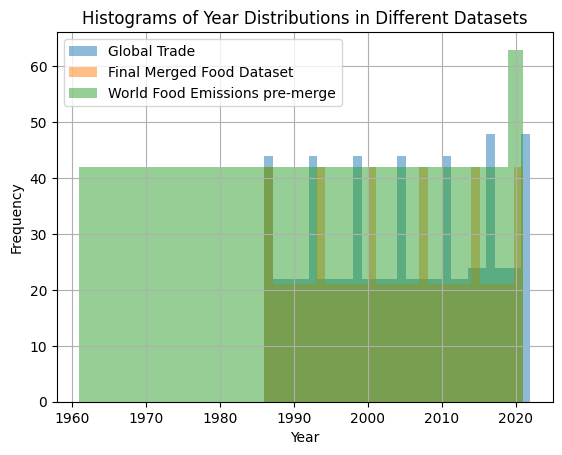

In [18]:
# Plot histograms with alpha for transparency
global_trade_df.Year.hist(alpha=0.5, bins=30)
world_food_emissions_comp.Year.hist(alpha=0.5, bins=30)
world_food_df.Year.hist(alpha=0.5, bins=30)

# Add a legend, title, and axis labels
plt.legend(['Global Trade', 'Final Merged Food Dataset', 'World Food Emissions pre-merge'])
plt.title('Histograms of Year Distributions in Different Datasets')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.grid(True)

# Show the plot
plt.show()

# Some visualizations about food global travel

### Items by distance and travel emissions

C:\Users\UX433F\AppData\Local\Temp\ipykernel_20332\2975732642.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\UX433F\AppData\Local\Temp\ipykernel_20332\2975732642.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\UX433F\AppData\Local\Temp\ipykernel_20332\2975732642.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\UX433F\AppData\Local\Temp\ipykernel_20332\2975732642.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set

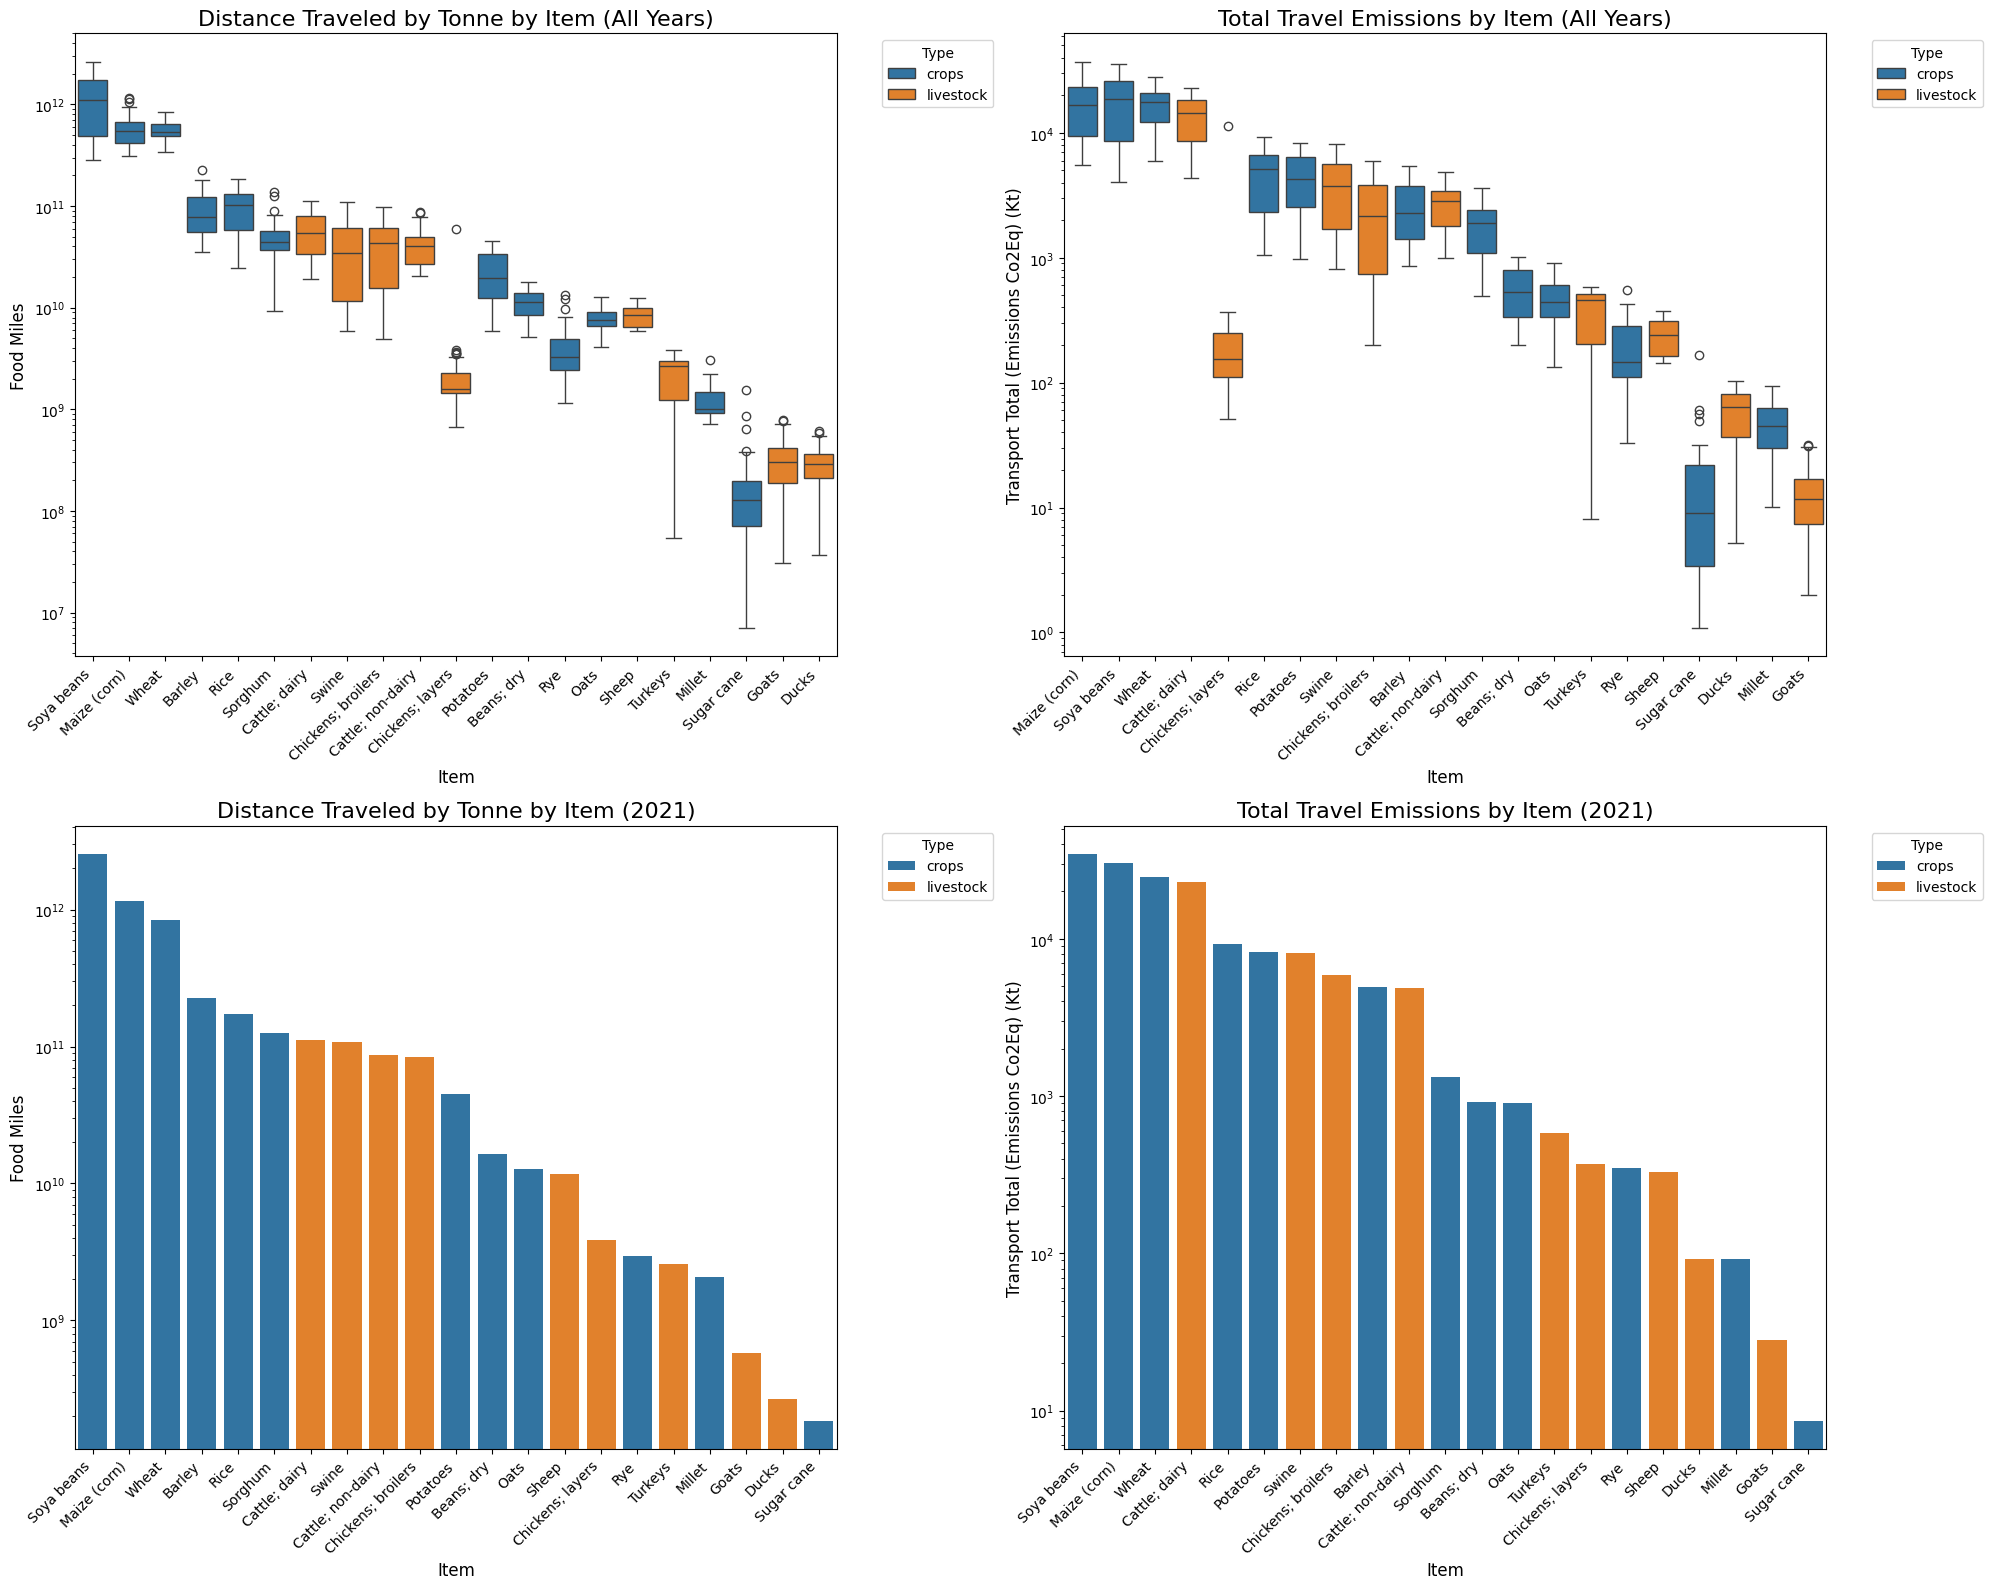

In [19]:
# Create the figure and axes
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# Function to create a boxplot
def create_boxplot(data, x, y, ax, title):
    df_sorted = data.sort_values(y, ascending=False)
    sns.boxplot(x=x, y=y, data=df_sorted, ax=ax, hue='crops_or_livestock')
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Item', fontsize=12)
    ax.set_ylabel(y.replace('_', ' ').title(), fontsize=12)
    ax.set_yscale('log')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')

def create_barplot(data, x, y, ax, title):
    df_sorted = data.sort_values(y, ascending=False)
    sns.barplot(x=x, y=y, data=df_sorted, ax=ax, hue='crops_or_livestock')
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Item', fontsize=12)
    ax.set_ylabel(y.replace('_', ' ').title(), fontsize=12)
    ax.set_yscale('log')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# All years plots
create_boxplot(world_food_emissions_comp, 'Item_emissions_table', 'food_miles', ax1, 'Distance Traveled by Tonne by Item (All Years)')
create_boxplot(world_food_emissions_comp, 'Item_emissions_table', 'transport_TOTAL_(emissions_CO2eq)_(kt)', ax2, 'Total Travel Emissions by Item (All Years)')

# 2021 data
world_food_emissions_2021 = world_food_emissions_comp[world_food_emissions_comp['Year'] == 2021]

# 2021 plots
create_barplot(world_food_emissions_2021, 'Item_emissions_table', 'food_miles', ax3, 'Distance Traveled by Tonne by Item (2021)')
create_barplot(world_food_emissions_2021, 'Item_emissions_table', 'transport_TOTAL_(emissions_CO2eq)_(kt)', ax4, 'Total Travel Emissions by Item (2021)')

# Adjust layout and show plot
plt.tight_layout()
plt.savefig('../plots/items_travel_distance_emissions_2x2.png', dpi=300, bbox_inches='tight')
plt.show()

## Relative emissions of production and travel per item

C:\Users\UX433F\AppData\Local\Temp\ipykernel_9272\2267091211.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\UX433F\AppData\Local\Temp\ipykernel_9272\2267091211.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\UX433F\AppData\Local\Temp\ipykernel_9272\2267091211.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\UX433F\AppData\Local\Temp\ipykernel_9272\2267091211.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xti

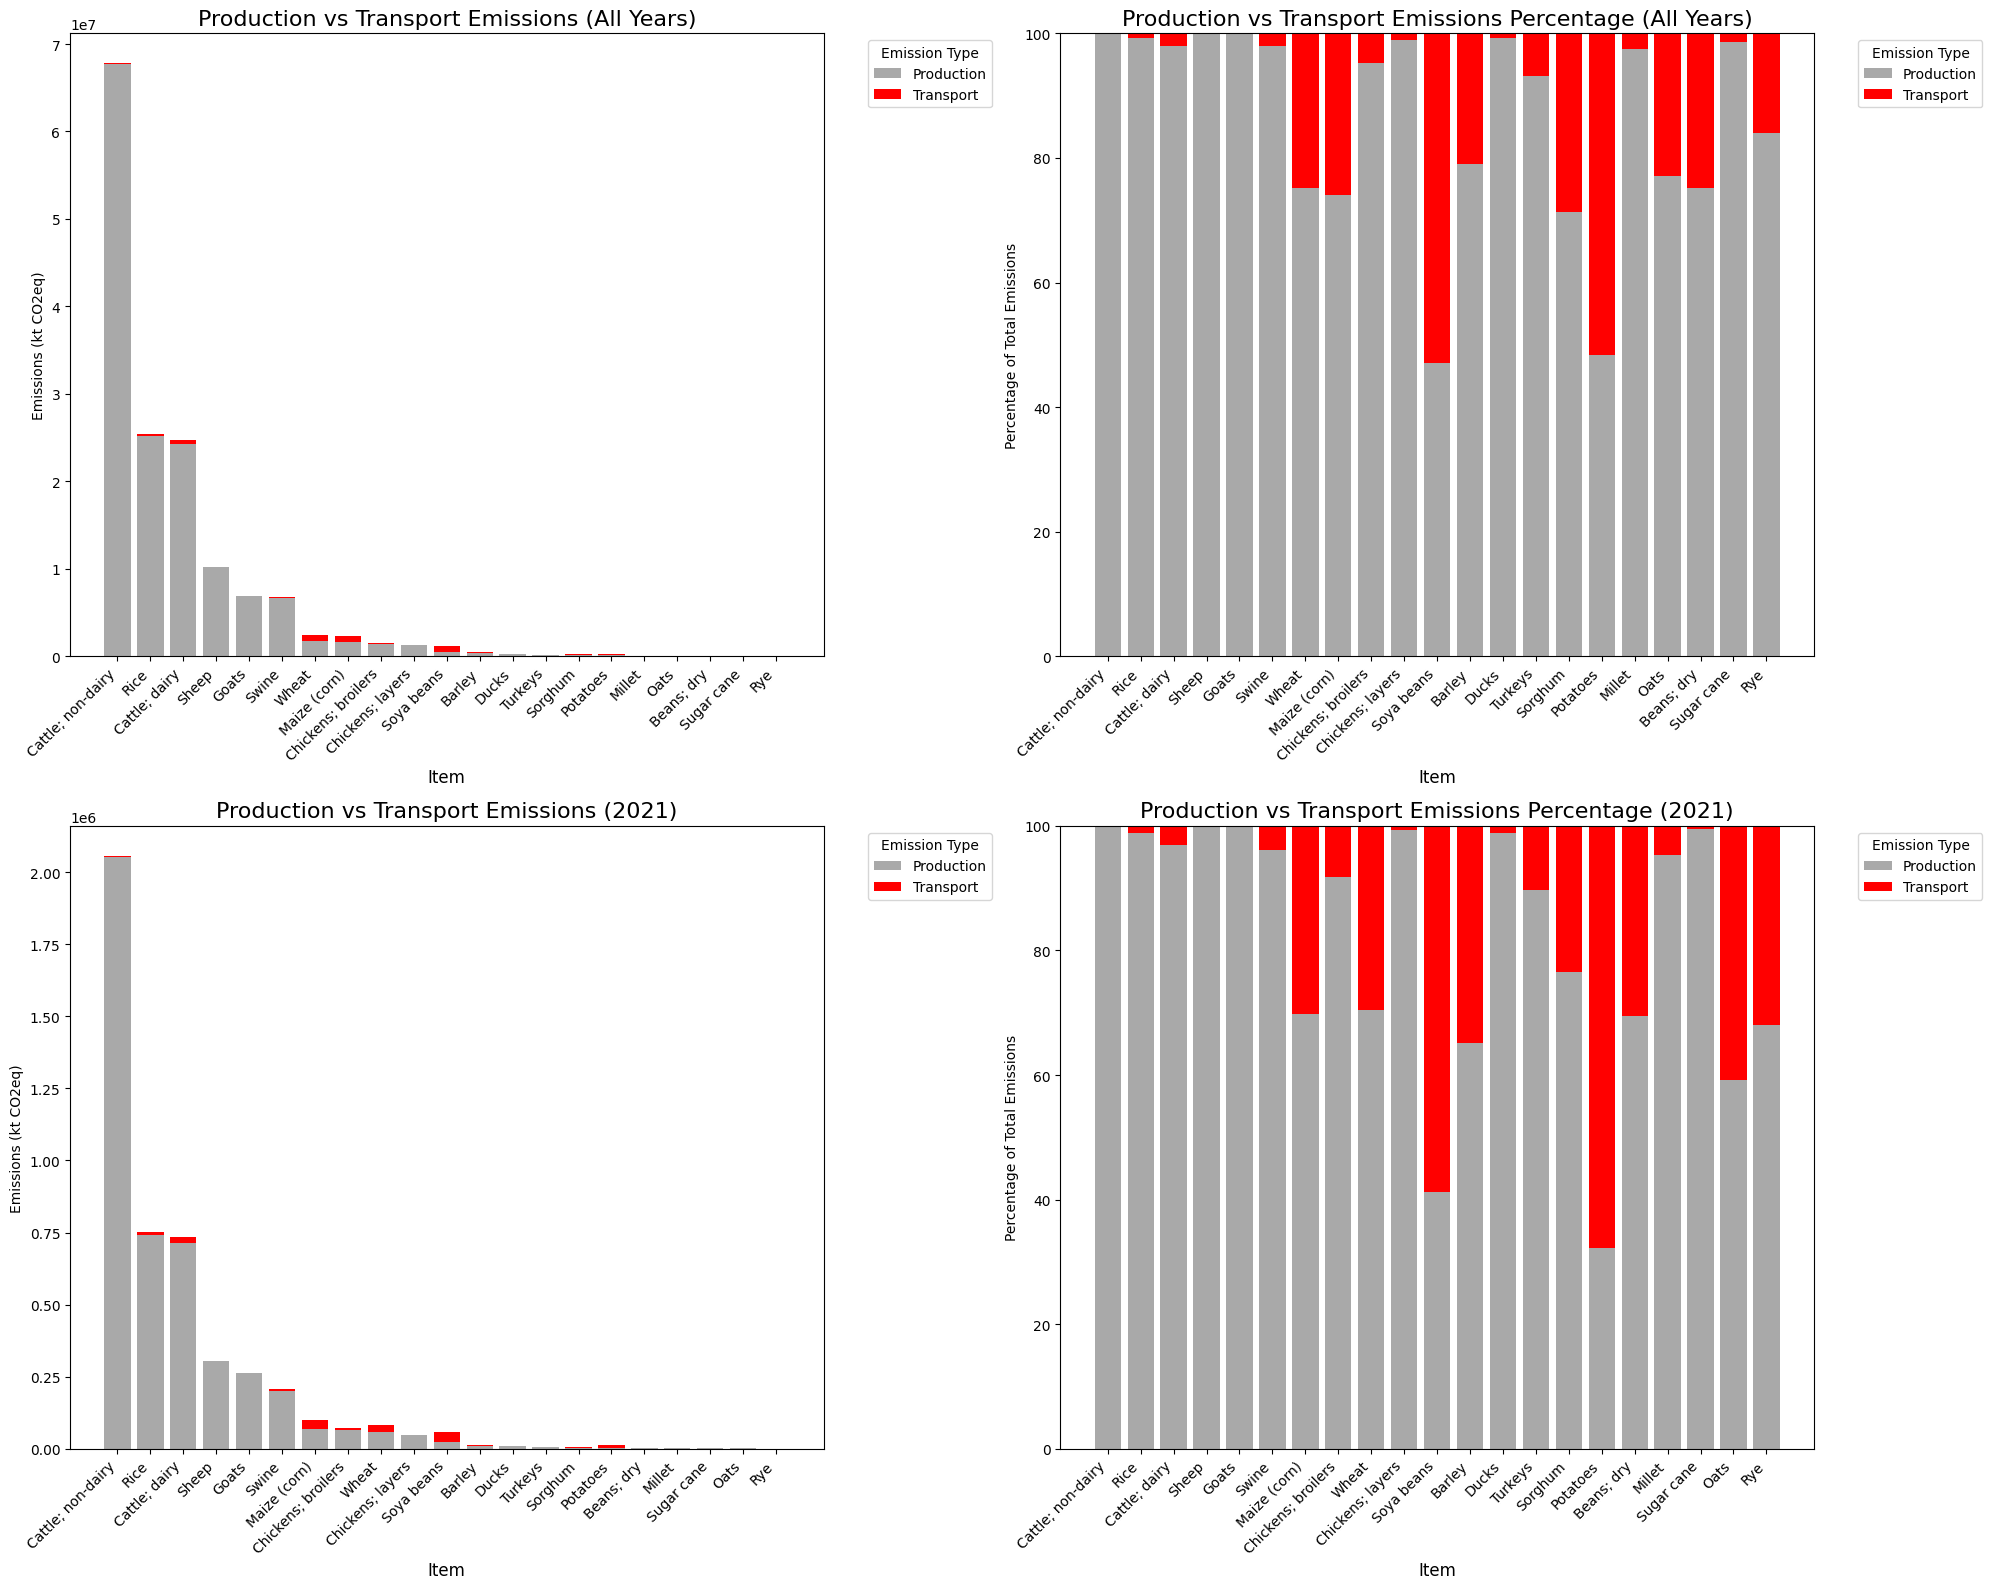

In [168]:
# Function to prepare data
def prepare_data(df):
    df['total_emissions'] = df['production_TOTAL_(emissions_CO2eq)_(kt)'] + df['transport_TOTAL_(emissions_CO2eq)_(kt)']
    df['production_percentage'] = df['production_TOTAL_(emissions_CO2eq)_(kt)'] / df['total_emissions'] * 100
    df['transport_percentage'] = df['transport_TOTAL_(emissions_CO2eq)_(kt)'] / df['total_emissions'] * 100
    return df

# Function to create a stacked bar plot
def create_stacked_bar(data, ax, percentage=False, title=''):
    # Group by Item and sum the emissions
    grouped_data = data.groupby('Item_emissions_table').agg({
        'production_TOTAL_(emissions_CO2eq)_(kt)': 'sum',
        'transport_TOTAL_(emissions_CO2eq)_(kt)': 'sum',
        'production_percentage': 'mean',
        'transport_percentage': 'mean'
    }).sort_values('production_TOTAL_(emissions_CO2eq)_(kt)', ascending=False)

    if percentage:
        production = grouped_data['production_percentage']
        transport = grouped_data['transport_percentage']
        ax.bar(grouped_data.index, production, label='Production', color='darkgrey')
        ax.bar(grouped_data.index, transport, bottom=production, label='Transport', color='r')
        ax.set_ylabel('Percentage of Total Emissions')
        ax.set_ylim(0, 100)
    else:
        production = grouped_data['production_TOTAL_(emissions_CO2eq)_(kt)']
        transport = grouped_data['transport_TOTAL_(emissions_CO2eq)_(kt)']
        ax.bar(grouped_data.index, production, label='Production', color='darkgrey')
        ax.bar(grouped_data.index, transport, bottom=production, label='Transport', color='r')
        ax.set_ylabel('Emissions (kt CO2eq)')

    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Item', fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.legend(title='Emission Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Prepare the data
world_food_emissions_comp = prepare_data(world_food_emissions_comp)
world_food_emissions_2021 = world_food_emissions_comp[world_food_emissions_comp['Year'] == 2021]

# Create the figure and axes
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# All years plots
create_stacked_bar(world_food_emissions_comp, ax1, percentage=False, title='Production vs Transport Emissions (All Years)')
create_stacked_bar(world_food_emissions_comp, ax2, percentage=True, title='Production vs Transport Emissions Percentage (All Years)')

# 2021 plots
create_stacked_bar(world_food_emissions_2021, ax3, percentage=False, title='Production vs Transport Emissions (2021)')
create_stacked_bar(world_food_emissions_2021, ax4, percentage=True, title='Production vs Transport Emissions Percentage (2021)')

# Adjust layout and show plot
plt.tight_layout()
plt.savefig('../plots/production_vs_transport_emissions_stacked_2x2.png', dpi=300, bbox_inches='tight')
plt.show()

## Save to parquet

In [170]:
world_food_emissions_comp.to_parquet('../data/FAOSTAT/clean_data/all_tables_processed/food_emissions/merged_food_prod_transport_emissions_world_v3.parquet')